<a href="https://colab.research.google.com/github/kumiori/mec647/blob/andres-conerecipe/iceice_1dcone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [19]:
try:
    import ufl
    import dolfinx
    import basix.ufl

except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx
    import ufl
    import basix.ufl


In [22]:
print(f"DOLFINx version: {dolfinx.__version__}\n based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")
print(f"UFL version: {ufl.__version__}\n based on GIT commit: nan of https://github.com/FEniCS/ufl/")


DOLFINx version: 0.6.0.0
 based on GIT commit: fdfd2d0627773a822ae8d450b77abad76d8b477b of https://github.com/FEniCS/dolfinx/
UFL version: 2022.3.0.dev0
 based on GIT commit: nan of https://github.com/FEniCS/ufl/


In [3]:
import sys
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [23]:
%%capture
try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML

In [5]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD

branch_name = 'andres-conerecipe'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  import mec647
  from mec647 import meshes
  from mec647.meshes import primitives
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 1553, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1553 (delta 177), reused 263 (delta 162), pack-reused 1267
Receiving objects: 100% (1553/1553), 95.17 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (808/808), done.


CRITICAL:root:DOLFINx version: 0.6.0.0 based on GIT commit: fdfd2d0627773a822ae8d450b77abad76d8b477b of https://github.com/FEniCS/dolfinx/


In [14]:
tdim = 1 
mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, 12)


Text(0.5, 1.0, 'Mesh with parameters, dimension 1')

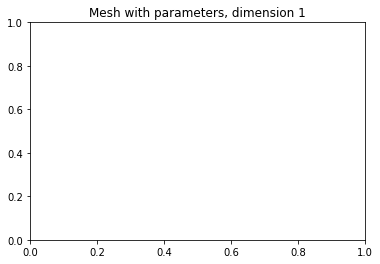

In [15]:
plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
plt.title(f"Mesh with parameters, dimension {tdim}")
# fig.savefig(f"one_mesh.png")

In [53]:
# Let's get the entire default set of parameters
import yaml

with open("mec647/test/parameters.yml") as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)
    parameters["model"]["model_dimension"] = 1
    parameters["model"]["model_type"] = '1D'
    parameters["model"]["mu"] = 1
    parameters["model"]["w1"] = 1
    parameters["model"]["k_res"] = 1e-4


In [24]:
ufl.FiniteElement

ufl.finiteelement.finiteelement.FiniteElement

In [29]:
# Functional Setting

element_u = basix.ufl.element("Lagrange", mesh.basix_cell(),
                              degree=1)

element_alpha = basix.ufl.element("DG", mesh.basix_cell(),
                              degree=0)

V_u = dolfinx.fem.functionspace(mesh, element_u) 
V_alpha = dolfinx.fem.functionspace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Pack state
state = {"u": u, "alpha": alpha}

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")

dx = ufl.Measure("dx", domain = mesh)
ds = ufl.Measure("ds", domain = mesh)


# Useful references
Lx = parameters.get("geometry").get("Lx")
Ly = parameters.get("geometry").get("Ly")

In [30]:
# Boundary sets

from dolfinx.fem import locate_dofs_geometrical, dirichletbc

dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))

dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))

# Boundary data

u_.interpolate(lambda x: np.ones_like(x[0]))

# Bounds (nontrivial)

alpha_lb.interpolate(lambda x: np.zeros_like(x[0]))
alpha_ub.interpolate(lambda x: np.ones_like(x[0]))

In [31]:
# Dofmap
map = mesh.topology.index_map(mesh.topology.dim)
num_cells = map.size_local + map.num_ghosts

In [59]:
# Boundary conditions

bcs_u = [
         dirichletbc(np.array(0., dtype=PETSc.ScalarType),
                      dofs_u_left,
                      V_u),
         dirichletbc(u_, dofs_u_right)
         ]

# bcs_alpha = [
#              dirichletbc(np.array(0., dtype = PETSc.ScalarType),
#                          np.concatenate([dofs_alpha_left, dofs_alpha_right]),
#                          V_alpha)
# ]

bcs_alpha = []

bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}


In [90]:
# Material behaviour
from mec647.models import DamageElasticityModel as Brittle

state = {"u": u, "alpha": alpha}

# mat_par = parameters.get()

def a(alpha):
    k_res = parameters["model"]['k_res']
    return (1 - alpha)**2 + k_res

def w(alpha):
    """
    Return the homogeneous damage energy term,
    as a function of the state
    (only depends on damage).
    """
    # Return w(alpha) function
    return alpha

def elastic_energy_density(state):
    """
    Returns the elastic energy density from the state.
    """
    # Parameters
    alpha = state["alpha"]
    u = state["u"]
    eps = ufl.grad(u)

    _mu = parameters["model"]['mu']
    energy_density = a(alpha) * _mu * ufl.inner(eps, eps)
    return energy_density

def damage_energy_density(state):
    """
    Return the damage dissipation density from the state.
    """
    # Get the material parameters
    _mu = parameters["model"]["mu"]
    _w1 = parameters["model"]["w1"]
    _ell = parameters["model"]["ell"]
    # Get the damage
    alpha = state["alpha"]
    # Compute the damage gradient
    grad_alpha = ufl.grad(alpha)
    # Compute the damage dissipation density
    D_d = _w1 * w(alpha) + _w1 * _ell**2 * ufl.dot(
        grad_alpha, grad_alpha)
    return D_d


total_energy = (elastic_energy_density(state) + damage_energy_density(state)) * dx



In [117]:
from mec647.solvers import SNESSolver
from mec647.utils import norm_H1, norm_L2

from dolfinx.fem.petsc import (
    assemble_matrix,
    apply_lifting,
    create_vector,
    create_matrix,
    set_bc,
    assemble_vector
    )

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    dirichletbc,
    form,
    locate_dofs_geometrical,
)


class _AlternateMinimisation:
    def __init__(self,
                total_energy,
                state,
                bcs,
                solver_parameters={},
                bounds=(dolfinx.fem.function.Function,
                        dolfinx.fem.function.Function)
                ):
        self.state = state
        self.alpha = state["alpha"]
        self.alpha_old = dolfinx.fem.function.Function(self.alpha.function_space)
        self.u = state["u"]
        self.alpha_lb = bounds[0]
        self.alpha_ub = bounds[1]
        self.total_energy = total_energy
        self.solver_parameters = solver_parameters

        V_u = state["u"].function_space
        V_alpha = state["alpha"].function_space

        energy_u = ufl.derivative(
            self.total_energy, self.u, ufl.TestFunction(V_u))
        energy_alpha = ufl.derivative(
            self.total_energy, self.alpha, ufl.TestFunction(V_alpha)
        )

        self.F = [energy_u, energy_alpha]

        self.elasticity = SNESSolver(
            energy_u,
            self.u,
            bcs.get("bcs_u"),
            bounds=None,
            petsc_options=self.solver_parameters.get("elasticity").get("snes"),
            prefix=self.solver_parameters.get("elasticity").get("prefix"),
        )

        self.damage = SNESSolver(
            energy_alpha,
            self.alpha,
            bcs.get("bcs_alpha"),
            bounds=(self.alpha_lb, self.alpha_ub),
            petsc_options=self.solver_parameters.get("damage").get("snes"),
            prefix=self.solver_parameters.get("damage").get("prefix"),
        )

    def solve(self, outdir=None):

        alpha_diff = dolfinx.fem.Function(self.alpha.function_space)

        self.data = {
            "iteration": [],
            "error_alpha_L2": [],
            "error_alpha_H1": [],
            "F_norm": [],
            "error_alpha_max": [],
            "error_residual_u": [],
            "solver_alpha_reason": [],
            "solver_alpha_it": [],
            "solver_u_reason": [],
            "solver_u_it": [],
            "total_energy": [],
        }
        for iteration in range(
            self.solver_parameters.get("damage_elasticity").get("max_it")
        ):
            with dolfinx.common.Timer("~Alternate Minimization : Elastic solver"):
                (solver_u_it, solver_u_reason) = self.elasticity.solve()
            with dolfinx.common.Timer("~Alternate Minimization : Damage solver"):
                (solver_alpha_it, solver_alpha_reason) = self.damage.solve()

            # Define error function
            self.alpha.vector.copy(alpha_diff.vector)
            alpha_diff.vector.axpy(-1, self.alpha_old.vector)
            alpha_diff.vector.ghostUpdate(
                addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
            )

            error_alpha_H1 = norm_H1(alpha_diff)
            error_alpha_L2 = norm_L2(alpha_diff)

            Fv = [assemble_vector(form(F)) for F in self.F]

            Fnorm = np.sqrt(
                np.array(
                    [comm.allreduce(Fvi.norm(), op=MPI.SUM)
                        for Fvi in Fv]
                ).sum()
            )

            error_alpha_max = alpha_diff.vector.max()[1]
            total_energy_int = comm.allreduce(
                assemble_scalar(form(self.total_energy)), op=MPI.SUM
            )
            residual_u = assemble_vector(self.elasticity.F_form)
            residual_u.ghostUpdate(
                addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE
            )
            set_bc(residual_u, self.elasticity.bcs, self.u.vector)
            error_residual_u = ufl.sqrt(residual_u.dot(residual_u))

            self.alpha.vector.copy(self.alpha_old.vector)
            self.alpha_old.vector.ghostUpdate(
                addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
            )

            self.data["iteration"].append(iteration)
            self.data["error_alpha_L2"].append(error_alpha_L2)
            self.data["error_alpha_H1"].append(error_alpha_H1)
            self.data["F_norm"].append(Fnorm)
            self.data["error_alpha_max"].append(error_alpha_max)
            self.data["error_residual_u"].append(error_residual_u)
            self.data["solver_alpha_it"].append(solver_alpha_it)
            self.data["solver_alpha_reason"].append(solver_alpha_reason)
            self.data["solver_u_reason"].append(solver_u_reason)
            self.data["solver_u_it"].append(solver_u_it)
            self.data["total_energy"].append(total_energy_int)




In [118]:
# Evolution solver
# import algorithms
# from algorithms import am

solver = _AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [ ]:
%%time
# Loop for evolution
from dolfinx.fem import assemble_scalar
import logging

loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

history_data = {
    "load": [],
    "elastic_energy": [],
    "dissipated_energy": [],
    "total_energy": [],
    # "solver_data": [],
    # "eigs": [],
    # "stable": [],
}

check_stability = []

for i_t, t in enumerate(loads):
    u_.interpolate(lambda x: t * np.ones_like(x[0]))
    u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                          mode=PETSc.ScatterMode.FORWARD)

    # update the lower bound
    alpha.vector.copy(alpha_lb.vector)
    alpha_lb.vector.ghostUpdate(
        addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
    )

    logging.critical(f"-- Solving for t = {t:3.2f} --")

    solver.solve()

    dissipated_energy = comm.allreduce(
        assemble_scalar(form(damage_energy_density(state) * dx)),
        op=MPI.SUM,
    )
    elastic_energy = comm.allreduce(
        assemble_scalar(form(elastic_energy_density(state) * dx)),
        op=MPI.SUM,
    )

    history_data["load"].append(t)
    history_data["dissipated_energy"].append(dissipated_energy)
    history_data["elastic_energy"].append(elastic_energy)
    history_data["total_energy"].append(elastic_energy+dissipated_energy)
    # history_data["solver_data"].append(solver.data)
    # history_data["eigs"].append(stability.data["eigs"])
    # history_data["stable"].append(stability.data["stable"])

    with XDMFFile(comm, f"{prefix}/{_nameExp}.xdmf", "a", encoding=XDMFFile.Encoding.HDF5) as file:
        file.write_function(u, t)
        file.write_function(alpha, t)

    if comm.rank == 0:
        a_file = open(f"{prefix}/{_nameExp}-data.json", "w")
        json.dump(history_data, a_file)
        a_file.close()

    # list_timings(MPI.COMM_WORLD, [dolfinx.common.TimingType.wall])
    print(history_data)



CRITICAL:root:-- Solving for t = 0.00 --


  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Fu